In [6]:
import pandas as pd

# Chargement des deux fichiers CSV
pollution_df = pd.read_csv("data/output/episodes_de_pollution_nettoyes.csv", sep=",", encoding="utf-8")
voirie_df = pd.read_csv("data/output/pvo_patrimoine_voirie_pvocomptagecriter_nettoye.csv", sep=",", encoding="utf-8")

# Affichage des premières lignes pour compréhension du contenu
pollution_df.head(), voirie_df.head()


(   id  gid  code_zone             zone        date    date_dif  code_pol  \
 0   1    1       2016  Zone Alpine Ain  2025-01-19  2025-01-18         8   
 1   2    2       2016  Zone Alpine Ain  2025-01-18  2025-01-17         8   
 2   3    3       2016  Zone Alpine Ain  2025-02-08  2025-02-07         7   
 3   4    4       2016  Zone Alpine Ain  2025-01-26  2025-01-25         7   
 4   5    5       2016  Zone Alpine Ain  2025-01-23  2025-01-22         5   
 
           polluant                etat   niveau com_court commentaire  \
 0  Dioxyde d'azote  PAS DE DEPASSEMENT  #19FF19     aucun       aucun   
 1  Dioxyde d'azote  PAS DE DEPASSEMENT  #19FF19     aucun       aucun   
 2            Ozone  PAS DE DEPASSEMENT  #19FF19     aucun       aucun   
 3            Ozone  PAS DE DEPASSEMENT  #19FF19     aucun       aucun   
 4  Particules PM10  PAS DE DEPASSEMENT  #19FF19     aucun       aucun   
 
    OBJECTID   SHAPE__Area  SHAPE__Length  
 0         1  3.359408e+09  346225.361125  
 1

In [7]:
# Conversion des dates au format datetime
pollution_df["date"] = pd.to_datetime(pollution_df["date"])
voirie_df["date"] = pd.to_datetime(voirie_df["date"])

# Création d'une variable binaire pour indiquer s'il y a pollution (dépassement)
pollution_df["pollution_detectee"] = pollution_df["etat"].apply(
    lambda x: 1 if "DEPASSEMENT" in x else 0
)

# Regrouper les données de pollution par date pour simplifier l'analyse (somme des indicateurs pollution)
pollution_by_date = pollution_df.groupby("date")[["pollution_detectee"]].sum().reset_index()

# Fusion avec les données de voirie sur la date
merged_df = pd.merge(voirie_df, pollution_by_date, on="date", how="left")

# Remplir les NaN par 0 (s'il n'y avait pas de pollution ce jour-là dans l'autre fichier)
merged_df["pollution_detectee"] = merged_df["pollution_detectee"].fillna(0)

# Afficher un aperçu des données fusionnées
merged_df[["date", "moyennejou", "pollution_detectee"]].head(10)


,date,moyennejou,pollution_detectee
0,2025-02-18,563.0,5
1,2025-03-23,3057.0,7
2,2025-03-27,3596.0,8
3,2025-03-02,4575.0,8
4,2025-03-10,6769.0,4
5,2025-02-13,12877.0,2
6,2025-01-22,1555.0,4
7,2025-01-16,6806.0,3
8,2025-02-05,4550.0,7
9,2025-04-06,24874.0,6


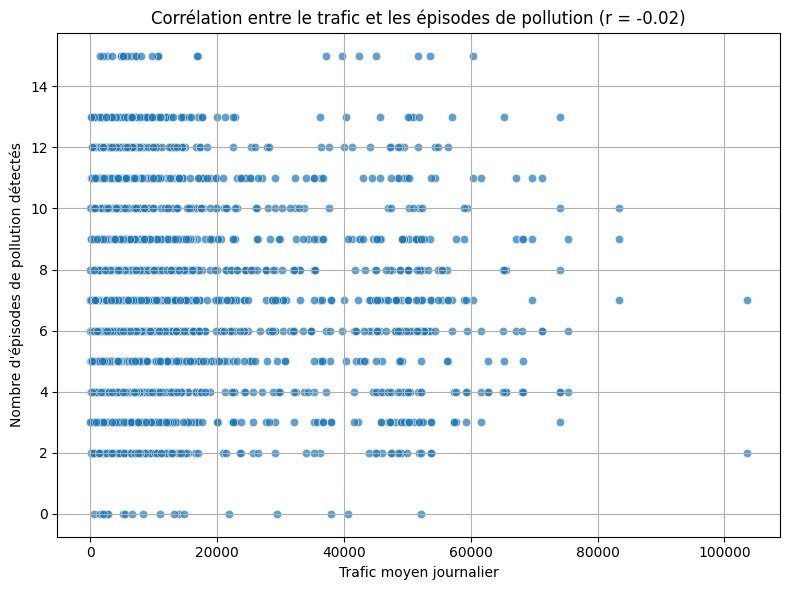

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul de la corrélation de Pearson
correlation = merged_df["moyennejou"].corr(merged_df["pollution_detectee"])

# Création du nuage de points
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df,
    x="moyennejou",
    y="pollution_detectee",
    alpha=0.7
)
plt.title(f"Corrélation entre le trafic et les épisodes de pollution (r = {correlation:.2f})")
plt.xlabel("Trafic moyen journalier")
plt.ylabel("Nombre d'épisodes de pollution détectés")
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from datetime import datetime
import os
from dotenv import load_dotenv

# Charger les variables d'environnement
load_dotenv()

# Configuration de la base de données
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '5432')
DB_NAME = os.getenv('DB_NAME', 'alatytics')
DB_USER = os.getenv('DB_USER', 'postgres')
DB_PASSWORD = os.getenv('DB_PASSWORD', 'postgres')

def create_table():
    """Crée la table pollution_trafic_jour si elle n'existe pas"""
    conn = psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        database=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD
    )
    cur = conn.cursor()
    
    cur.execute("""
        CREATE TABLE IF NOT EXISTS pollution_trafic_jour (
            date DATE PRIMARY KEY,
            pollution_detectee INT,
            moyenne_journaliere FLOAT
        )
    """)
    
    conn.commit()
    cur.close()
    conn.close()

In [24]:
def load_data():
    """Charge les données depuis les fichiers CSV et les insère dans la base de données"""
    # Lecture des fichiers CSV
    pollution_df = pd.read_csv('data/episodes_de_pollution_prevus_ou_constates.csv')
    trafic_df = pd.read_csv('data/pvo_patrimoine_voirie_pvocomptagecriter.csv')
    
    # Conversion des dates
    pollution_df['date'] = pd.to_datetime(pollution_df['date_prevision']).dt.date
    trafic_df['date'] = pd.to_datetime(trafic_df['date']).dt.date
    
    # Agrégation des données de pollution par jour
    pollution_agg = pollution_df.groupby('date').size().reset_index(name='pollution_detectee')
    
    # Agrégation des données de trafic par jour
    trafic_agg = trafic_df.groupby('date')['moyennejou'].mean().reset_index(name='moyenne_journaliere')
    
    # Fusion des données
    merged_df = pd.merge(pollution_agg, trafic_agg, on='date', how='outer')
    merged_df = merged_df.fillna(0)
    
    # Connexion à la base de données
    engine = create_engine(f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
    
    # Insertion des données
    merged_df.to_sql('pollution_trafic_jour', engine, if_exists='replace', index=False)

if __name__ == "__main__":
    print("Création de la table...")
    create_table()
    
    print("Chargement des données...")
    load_data()
    
    print("Chargement terminé avec succès!") 

Création de la table...
Chargement des données...
Chargement terminé avec succès!
